In [38]:
%matplotlib inline

In [37]:
# So we can use the *thesislib* package
import sys
import os

module_path = os.path.abspath("..")

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from thesislib.utils import pathutils
import json

In [3]:
patients_csv = pathutils.get_data_file("exploration_II/data/patients.csv")
conditions_csv = pathutils.get_data_file("exploration_II/data/patient_conditions.csv")
symptoms_csv = pathutils.get_data_file("exploration_II/data/patient_condition_symptoms.csv")

In [4]:
import pandas as pd
import numpy as np

In [39]:
from glob import glob
import matplotlib.pyplot as plt

In [198]:
def extract_condition_symptom_from_modules(module_name):
    with open(module_name) as fp:
        module = json.load(fp)
    condition_code = None
    condition_name = None
    symptoms = []
    
    states = module.get('states')
    for state in states.values():
        state_type = state.get('type')
        if state_type == 'ConditionOnset':
            condition_code = state.get('codes')[0].get('code')
            condition_name = state.get('codes')[0].get('display')
        elif state_type == 'Symptom':
            symptom_code = state.get('symptom_code').get('code')
            symptoms.append(symptom_code)
    return condition_code, condition_name, set(symptoms)

In [123]:
generating_synthea_modules = glob(pathutils.get_data_file("exploration_II/data/modules/*.json"))
num_unique_conditions = len(generating_synthea_modules)

In [8]:
patients = pd.read_csv(patients_csv, parse_dates=['BIRTHDATE'])

In [9]:
conditions = pd.read_csv(conditions_csv, parse_dates=['ONSET', 'DIAGNOSED'])

In [10]:
symptoms = pd.read_csv(symptoms_csv)

In [11]:
condition_codes = conditions.CODE.unique().tolist()

In [124]:
# we should expect 9 conditions only
assert len(condition_codes) == num_unique_conditions, "Got more or less than %d conditions" % num_unique_conditions

In [199]:
condition_symptom_map = {}
condition_name_map = {}
for module in generating_synthea_modules:
    condition_code, condition_name, symptom_list = extract_condition_symptom_from_modules(module)
    condition_symptom_map[condition_code] = symptom_list
    condition_name_map[condition_code] = condition_name

In [14]:
# we know the different symptoms for every condition. No condition should have symptoms outside the prescribed list
# first merge the condition and the symptoms
symptoms_w_conditions = symptoms.merge(conditions, how='left', left_on='CONDITION_ID', right_on='Id', suffixes=('_symp', ''))

In [15]:
# are there symptoms with no conditions ?!
assert sum(symptoms_w_conditions['CONDITION_ID'].isna()) == 0

In [16]:
# next group by condition code (CODE) and get the unique Symptom codes per group
unique_symptoms_per_group = symptoms_w_conditions.groupby('CODE').SYMPTOM_CODE.unique()

In [17]:
# now compare with the expected value!
for condition_code, unique_symptoms in unique_symptoms_per_group.iteritems():
    expected_symptoms = condition_symptom_map.get(condition_code)
    actual_symptoms = set(unique_symptoms)
    assert len(expected_symptoms) >= len(actual_symptoms) # it's possible we didn't capture all the symptoms in the generated data
    diff = actual_symptoms - expected_symptoms
    assert len(diff) == 0 # but we should never get symptoms that are not in the expected set

In [18]:
# the next thing we need to confirm is the business with the age difference
# The onset date for a condition should never be earlier than the birthdate of a patient
# first we combined the condition and the patient data frames together
conditions_w_patients = conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [19]:
conditions_w_patients['AGE'] = (conditions_w_patients['ONSET'] - conditions_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

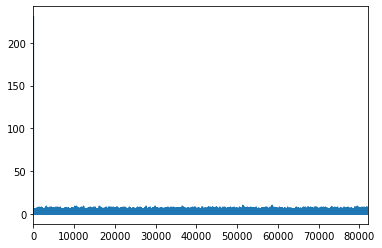

In [55]:
conditions_w_patients['AGE'].plot()

In [25]:
# there should be no negative age
positive_age = conditions_w_patients['ONSET'] >= conditions_w_patients['BIRTHDATE']

In [26]:
num_positive_ages = sum(positive_age)
num_conditions = conditions_w_patients.shape[0]
assert num_positive_ages == num_conditions, "Expected : %d but got %d" % (num_conditions, num_positive_ages)

AssertionError: Expected : 82107 but got 82103

In [27]:
# let's get the erring conditions
erring_conditions_w_patients = conditions_w_patients[conditions_w_patients['ONSET'] < conditions_w_patients['BIRTHDATE']]

In [28]:
erring_conditions_w_patients[['PATIENT', 'BIRTHDATE', 'ONSET', 'AGE', 'DIAGNOSED']]

,PATIENT,BIRTHDATE,ONSET,AGE,DIAGNOSED
28,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1954-07-03,225,1954-07-03
29,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1957-06-22,228,1957-06-22
30,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1958-09-20,230,1958-09-20
31,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1960-02-17,231,1960-02-17


From the above, we see that it does actually happen that the birthdate is less than the diagnosed age!

We see that this is never the case in the original synthea implementation, which suggests that something is faulty with our implementation (and as a result the entire dataset too perhaps)!

How about the conditions.csv file generated by the modified synthea generator. Does this also have this effect ??

In [60]:
other_conditions_csv = pathutils.get_data_file("exploration_II/data/conditions.csv")

In [30]:
other_conditions = pd.read_csv(other_conditions_csv, parse_dates=['START'])

In [61]:
other_conditions.shape[0]

84323

In [63]:
# filter out conditions that we are not interested in
symcat_conditions = [item for item in other_conditions.CODE.unique() if len(item) == 56]

In [65]:
other_conditions = other_conditions[other_conditions.CODE.isin(symcat_conditions)]

In [66]:
other_condition_w_patients = other_conditions.merge(patients, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [67]:
other_condition_w_patients['AGE'] = (other_condition_w_patients['START'] - other_condition_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

In [68]:
other_is_negative = other_condition_w_patients['START'] < other_condition_w_patients['BIRTHDATE']

In [69]:
num_other_is_negative = sum(other_is_negative)
assert num_other_is_negative == 0, "Expected 0 but got %d" % num_other_is_negative

AssertionError: Expected 0 but got 4

We see that this does indeed happen with the conditions generated in the conditions csv file. Though they are ignored. 

In [70]:
erring_other = other_condition_w_patients[other_is_negative]

In [71]:
erring_other[['PATIENT', 'BIRTHDATE', 'START', 'AGE']]

,PATIENT,BIRTHDATE,START,AGE
24,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1954-07-03,225
25,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1957-06-22,228
26,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1958-09-20,230
27,ad49603b-f4ac-411d-acbd-339119fc7212,1984-08-14,1960-02-17,231


Next we check if this was in the original synthea implementation as this would help figure where the issue is.

In [77]:
patients_orig_csv = pathutils.get_data_file("exploration_II/data/patients_orig.csv")
conditions_orig_csv = pathutils.get_data_file("exploration_II/data/conditions_orig.csv")

In [78]:
orig_patients = pd.read_csv(patients_orig_csv, parse_dates=['BIRTHDATE'])

In [79]:
orig_conditions = pd.read_csv(conditions_orig_csv, parse_dates=['START'])

In [80]:
orig_condition_w_patients = orig_conditions.merge(orig_patients, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [81]:
orig_condition_w_patients['AGE'] = (orig_condition_w_patients['START'] - orig_condition_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

In [82]:
orig_is_positive = orig_condition_w_patients['START'] >= orig_condition_w_patients['BIRTHDATE']

In [83]:
num_orig_positve = sum(orig_is_positive)

In [84]:
expected_orig_positve = orig_condition_w_patients.shape[0]

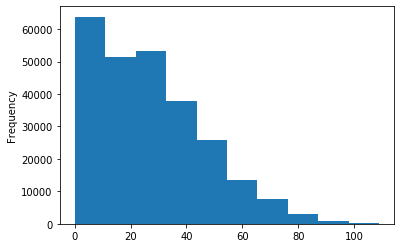

In [88]:
orig_condition_w_patients['AGE'].plot.hist()

We see that this issue does not occur in the original synthea implementation. 
What happens if we use our custom modules in the original synthea implementation?

Is this perhaps a function of the modules or of the code?

In [104]:
# trying with original synthea, but generated using custom generic modules
patients_orig_synth_csv = pathutils.get_data_file("exploration_II/data/patients_synth_orig.csv")
conditions_orig_synth_csv = pathutils.get_data_file("exploration_II/data/conditions_synth_orig.csv")

In [105]:
patients_orig_synth = pd.read_csv(patients_orig_synth_csv,parse_dates=['BIRTHDATE'])
conditions_orig_synth = pd.read_csv(conditions_orig_synth_csv, parse_dates=['START'])

In [106]:
synt_orig_condition_w_patients = conditions_orig_synth.merge(patients_orig_synth, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [107]:
# take only the synthea conditions
synth_orig_conditions = [item for item in conditions_orig_synth.CODE.unique() if len(item) == 56]

In [108]:
conditions_orig_synth = conditions_orig_synth[conditions_orig_synth.CODE.isin(synth_orig_conditions)]

In [109]:
conditions_orig_synth_w_patients = conditions_orig_synth.merge(patients_orig_synth, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [110]:
conditions_orig_synth_w_patients['AGE'] = (conditions_orig_synth_w_patients['START'] - conditions_orig_synth_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

In [111]:
synth_orig_is_negative = conditions_orig_synth_w_patients['START'] < conditions_orig_synth_w_patients['BIRTHDATE']

In [112]:
num_synth_negative = sum(synth_orig_is_negative)

In [113]:
assert num_synth_negative == 0, "Expected 0 got %d" % num_synth_negative

So we see that this is because of a bug in our implementation for sure!

We do not get the error when we generate the data using the original synthea implementation

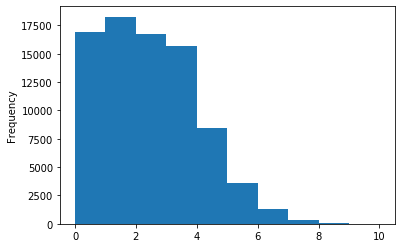

In [114]:
# how does the age plot look?
conditions_orig_synth_w_patients['AGE'].plot.hist()

We see that the age is distributed between 0 and 10 (so only children) and we don't get any elderly patients. 

This is probably due to the incidence limit being fixed and that already for children (age < 14) the probability of contracting the disease is relatively high, typically > 20%. 

The timestep is also 1 week. This means that in one year, there are 52 attempts to contract the disease with a limit of max of 3 tries. The odds are therefore quite high that you max out the inicidence limit of 3 before you get old.

A solution to this age issue would be two fold:
- Generate modules with a higher incidence limit, say 10 cases
- Increase the timestep from 1 week to 1 year ? (We don't care too much for encounters really, so this should not be a problem)

### Comments on issue with onset being less than the birthdate

- This is a serious issue and the reason for the issue does not immediately reveal itself
- My proposal:
    - Adjust the synthea module generator to have encounters wrap the conditions and the symptoms
    - We know the modules we build would have a one to one mapping between conditions and encounters
    - We also know that because conditions would onset and be diagnosed immediately  (because it onset's in the target encounter) we know that the onset date would be the `START` property of the conditions as they are now.
    - We can then add the symptoms we are interested in and tie those to the condition via an encounter.
    - We make minimalistic changes and rely on the nature of the generic modules to enforce the desired attributes!
- **Note**
    - When exporting data, number of years to keep re: history has to be the all the years i.e set to 0
    - The encounter module must be disabled. We want to disable funky encounters from being generated
        - One way to know if generation is fine is that there must be as many encounters as there are condtions i.v.m the one-to-one mapping between conditions and encounters
    - Sample command to generate 10k patients:
        - ```./run_synthea -p 10000 --exporter.fhir.export=false --exporter.practitioner.fhir.export=false --exporter.csv.export=true --exporter.years_of_history=0```

In [143]:
patients_new_csv = pathutils.get_data_file("exploration_II/data/new/patients.csv")
conditions_new_csv = pathutils.get_data_file("exploration_II/data/new/conditions.csv")
symptoms_new_csv = pathutils.get_data_file("exploration_II/data/new/symptoms.csv")

In [144]:
patients_new = pd.read_csv(patients_new_csv, parse_dates=['BIRTHDATE'])
conditions_new = pd.read_csv(conditions_new_csv, parse_dates=['START', 'STOP'])
symptoms_new = pd.read_csv(symptoms_new_csv)

In [145]:
# run through all the checks as before
# we should expect 9 conditions only
new_condition_codes = conditions_new.CODE.unique().tolist()
assert len(new_condition_codes) == num_unique_conditions, "Got more or less than %d conditions" % num_conditions

In [146]:
# we know the different symptoms for every condition. No condition should have symptoms outside the prescribed list
# first merge the condition and the symptoms
new_symptoms_w_conditions = symptoms_new.merge(conditions_new, how='left', left_on='ENCOUNTER', right_on='ENCOUNTER', suffixes=('_symp', ''))

In [147]:
# every symptom belongs to a condition
new_num_symp_no_condition = sum(new_symptoms_w_conditions.CODE.isna())
assert new_num_symp_no_condition == 0, "Expected 0 got %d" % new_num_symp_no_condition

In [149]:
# next group by condition code (CODE) and get the unique Symptom codes per group
new_unique_symptoms_per_group = new_symptoms_w_conditions.groupby('CODE').SYMPTOM_CODE.unique()

In [150]:
# now compare with the expected value!
for condition_code, unique_symptoms in new_unique_symptoms_per_group.iteritems():
    expected_symptoms = condition_symptom_map.get(condition_code)
    actual_symptoms = set(unique_symptoms)
    assert len(expected_symptoms) >= len(actual_symptoms) # it's possible we didn't capture all the symptoms in the generated data
    diff = actual_symptoms - expected_symptoms
    assert len(diff) == 0 # but we should never get symptoms that are not in the expected set

In [152]:
# Now for the age business
new_conditions_w_patients = conditions_new.merge(patients_new, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [153]:
new_conditions_w_patients['AGE'] = (new_conditions_w_patients['START'] - new_conditions_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

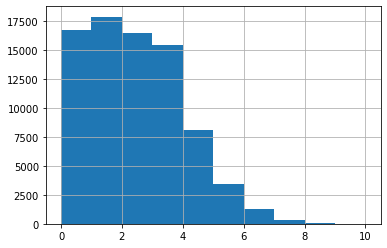

In [154]:
new_conditions_w_patients['AGE'].hist()

In [155]:
# there should be no negative age
new_negative_age = new_conditions_w_patients['START'] < new_conditions_w_patients['BIRTHDATE']

In [156]:
num_new_neg_ages = sum(new_negative_age)
assert num_new_neg_ages == 0, "Expected : %d but got %d" % (0, num_new_neg_ages)

This seems to solve the problem - at least of the age discrepancies. 

Also we generate one less file. And the symptoms file generated now contains only just the data that we need. Tying symptoms to conditions using encounters also means that we don't need a seprate join

The next hurdle would be getting the age to more representative by playing around with the timestemp, the incidence limits and the delay in the modules

In [208]:
patients_age_csv = pathutils.get_data_file("exploration_II/data/age/patients.csv")
conditions_age_csv = pathutils.get_data_file("exploration_II/data/age/conditions.csv")

In [209]:
patients_age = pd.read_csv(patients_age_csv, parse_dates=['BIRTHDATE'])
conditions_age = pd.read_csv(conditions_age_csv, parse_dates=['START', 'STOP'])

In [210]:
age_conditions_w_patients = conditions_age.merge(patients_age, how='left', left_on='PATIENT', right_on='Id', suffixes=('_cond', ''))

In [211]:
# assert no negative age
neg_age = age_conditions_w_patients['START'] < age_conditions_w_patients['BIRTHDATE']
num_neg_age = sum(neg_age)
assert num_neg_age == 0, "Expected 0 got %d" % num_neg_age

In [212]:
age_conditions_w_patients['AGE'] = (age_conditions_w_patients['START'] - age_conditions_w_patients['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)

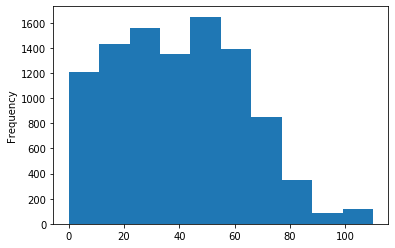

In [213]:
# how old are the patients typically?
p_age = (np.datetime64('2020-04-01') - patients_age['BIRTHDATE']).astype('timedelta64[Y]').astype(np.uint8)
p_age.plot.hist()

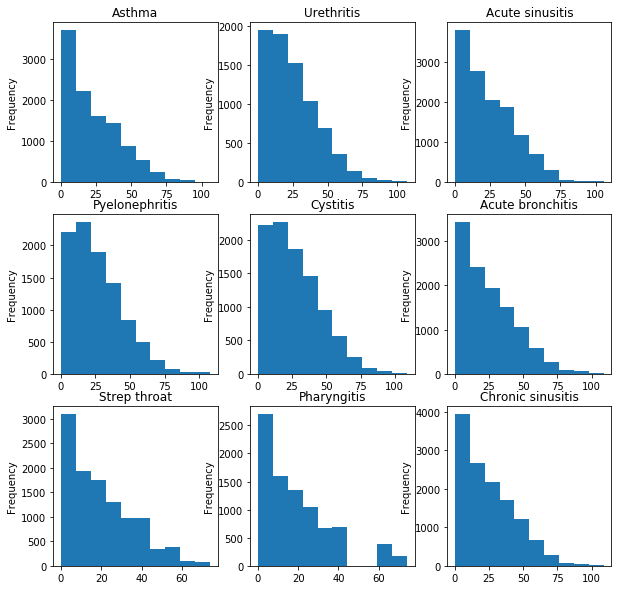

In [214]:
# for each condition let's get the age
fig, axes = plt.subplots(3, 3)
fig.set_size_inches(10, 10)

unique_conditions = age_conditions_w_patients.CODE.unique()
for idx, item in enumerate(unique_conditions):
    xdx = idx // 3
    ydx = idx % 3
    axes[xdx, ydx].set_title(plt_title)
    plt.sca(axes[xdx, ydx])
    plt_title = condition_name_map[item]
    age_conditions_w_patients[age_conditions_w_patients['CODE'] == item]['AGE'].plot.hist(title=plt_title)

I have tried a whole different set of options:
- increased the incidence limit
- Pushed the delay to try and force "age bracket" escape
- Added a delay after treatment is complete to also force the age to change on next run
- But still the young patients dominate each disease. 
- Until this is fixed, it would be advisable to not rely too heavily on the effects of age on the results. The thing though is that since the age seems to be similarly distributed across the conditions it suggests that telling something about the age should not affect the decision too much. Sad but better than it being a false indicator

In [218]:
p_age_1 = ((np.datetime64('2020-04-01') - patients_age['BIRTHDATE']).astype('timedelta64[M]')/12).astype(np.float32)

In [219]:
p_age.max()

110

In [220]:
p_age_1.max()

110.91666412353516